In [1]:
import argparse
import os

import random

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
from torch.nn import functional as F
import torchvision
from tqdm import tqdm
from math import sqrt

# CHEKHOV GAN

![Screenshot from 2022-11-10 23-57-28](https://user-images.githubusercontent.com/113635391/201581232-a8162235-aa9d-407e-ae4d-1d1d301b1bef.png)

## Data preprocessing and initialising variables

In [2]:
# Using celebA dataset 

batch_size = 128
image_size = 64
num_ch = 3
latent_dim = 100

lr = 0.0002

preprocessData = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5],[0.5])
                            ])

tranform=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])
dataset=torchvision.datasets.ImageFolder(root="./img_align_celeba",transform=tranform)
N=len(dataset)/batch_size
train_data=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True, num_workers=2)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device being used is: ", device)



def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
K=5
C=0.01
m=N//K

Device being used is:  cuda:0


## Model Building

In [5]:

# Initializing a queue

class Queue:  
  def __init__(self,K):  
      self.queue = list([None])*K
      self.K=K
      self.l=0
  def push(self,x):
      if self.l<self.K:
          self.queue[self.l]=x
          self.l+=1
      else:
          self.queue=self.queue[1:]
          self.queue.append(x)
  def get_K(self):  
      return self.K
  def get_l(self):
      return self.l


# Followed DC GAN architecture

def get_L2(model):
    l2_reg = torch.tensor(0.,device=device)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_reg


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.decode = nn.Sequential(
            #Input = [num_ch x 64 x 64] 
            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            #Output = [1 x 1 x 1]
        )

    def forward(self, input):
        out = self.decode(input)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            #Input = [100 x 1 x 1] 
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, num_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            #Output = [num_ch x 64 x 64] 
        )

    def forward(self, input):
        out = self.encode(input)
        return out
    
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(init_weights)
G.apply(init_weights)

Generator(
  (encode): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


## setting up optimiser

In [ ]:
loss = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
real_label = 1.
fake_label = 0.
losses_g = []
losses_d = []
num_epochs = 20
steps = 0

## init step in the algorithm

In [7]:
# This step byapasses the init.of zero functions

Q_0=Queue(K=K)
Q_1=Queue(K=K)


G.zero_grad()
loss_G=get_L2(G)
loss_G.backward()
optimizerG.step()

D.zero_grad()
loss_D=get_L2(D)
loss_D.backward()
optimizerD.step()

Q_0.push(D)
Q_1.push(G)



## Training

In [9]:
t=0

for epoch in tqdm(range(num_epochs)):
    for i, data in enumerate(train_data, 0):
        t+=1
        
        loss_list=[]
        D.zero_grad()
        real_img = data[0].to(device)
        current_bs = real_img.size(0)
        label = torch.full((current_bs,), real_label, dtype=torch.float, device=device)

        output = D(real_img).view(-1)
        loss_Dreal = loss(output, label)
        loss_Dreal=loss_Dreal*Q_1.l
        loss_Dreal.backward(retain_graph=True)
        # Train D with generated images
        
        total_loss_fake_list=[]
        total_loss = torch.empty((1,), device=device, requires_grad=True)
        fake_data_list=[]
        label_list=[] 
        
        for g in Q_1.queue: 
            if g==None:
                continue
            noise = torch.randn(current_bs, latent_dim, 1, 1, device=device)
            fake = g(noise)
            fake_data_list.append(fake.detach())
            label_list.append(label.fill_(fake_label))
            
        fake_data_tensor=torch.cat(fake_data_list)
        label_tensor=torch.cat(label_list)
        output = D(fake_data_tensor).view(-1)
        
        loss_Dfake = loss(output, label_tensor)
        loss_Dfake.backward()

        reg_loss_D=-1*C*float((1/sqrt(t)))*get_L2(D)
        reg_loss_D.backward()
        lossD=loss_Dfake+loss_Dreal+reg_loss_D
        optimizerD.step()
        # Train G
         
        G.zero_grad()
        label.fill_(real_label)
        noise = torch.randn(current_bs, latent_dim, 1, 1, device=device)
        fake = G(noise)
        total_loss_G=torch.tensor(0.,device=device)
        output_data_list=[]
        output_label_list=[]
        for d in Q_0.queue: 
            if d==None:
                continue
            output = d(fake).view(-1)
            output_data_list.append(output)
            output_label_list.append(label)
        output_data_tensor=torch.cat(output_data_list)
        output_label_tensor=torch.cat(output_label_list)
        loss_G = loss(output_data_tensor,output_label_tensor)
        loss_G.backward()
        
        reg_loss_G=C*float((1/sqrt(t)))*get_L2(G)
        reg_loss_G.backward()
        lossG=loss_G+reg_loss_G
        optimizerG.step()

        losses_g.append(lossG.item())
        losses_d.append(lossD.item())
        
        # update Queue-Following the algorithm given in the paper
        
        if Q_0.l==K and t%m==0:
            Q_0.push(D)
            Q_1.push(G)
            m=m+10
        elif Q_0.l<K:
            Q_0.push(D)
            Q_1.push(G)
            

            

        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(train_data), lossD.item(), lossG.item()))
            
        steps += 1

  0%|          | 0/5 [00:00<?, ?it/s]

[0/5][0/1583]	Loss_D: 1.3536	Loss_G: 3.8649
[0/5][1000/1583]	Loss_D: 1.8155	Loss_G: 5.3008


 20%|██        | 1/5 [03:11<12:45, 191.39s/it]

[1/5][0/1583]	Loss_D: 0.7085	Loss_G: 2.5037
[1/5][1000/1583]	Loss_D: 3.0384	Loss_G: 2.0579


 40%|████      | 2/5 [06:06<09:06, 182.06s/it]

[2/5][0/1583]	Loss_D: 1.9906	Loss_G: 2.7591
[2/5][1000/1583]	Loss_D: 0.9640	Loss_G: 1.5111


 60%|██████    | 3/5 [08:50<05:47, 173.59s/it]

[3/5][0/1583]	Loss_D: 1.1611	Loss_G: 0.5922
[3/5][1000/1583]	Loss_D: 1.8703	Loss_G: 0.4645


 80%|████████  | 4/5 [11:16<02:42, 162.72s/it]

[4/5][0/1583]	Loss_D: 1.3802	Loss_G: 0.6795
[4/5][1000/1583]	Loss_D: 0.9562	Loss_G: 1.8030


100%|██████████| 5/5 [13:29<00:00, 161.95s/it]


## Generating new samples

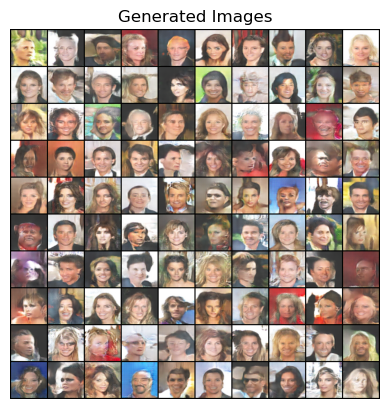

In [10]:
# Generating new samples using the trained generator

z = torch.randn(100, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()
fake.shape

plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, normalize=True), (1,2,0)))
plt.show()